# Data preprocessing and model preparation

In [42]:
library(data.table) #fread
library(dplyr)
library(geosphere) # Calculate vehicle distance
library(lubridate)# Date column extraction
library(robfilter)# Smooth the data
library(ggplot2) # Plot

In [44]:
library(gridExtra)

Warning message:
"package 'gridExtra' was built under R version 3.6.3"

Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




In [2]:
# adjust the R limit
memory.limit(size=249200)

[1] 249200

## Input location data and data preprocessing

In [2]:
# Read data from folder
# Suggestion: Just do one year at one time. One year's table has 94363502 rows(green)
YEARLIST = c('19')
MONTHlIST = c("04") #FOR FULL TABLE
DISTANCE_FILEPATH = "../../data/raw/vehicle-location/"

In [3]:
# aggregrate_trajectory_table
aggregate_line_trajectories = function(year, month){
    assign("dg", fread(paste(DISTANCE_FILEPATH, paste("lightrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    assign("dh", fread(paste(DISTANCE_FILEPATH, paste("heavyrail", "trajectories", month, year, ".csv", sep = "-", collapse = ""), sep="")))
    # Combine the original tables to a single one for analysis
    dg = subset(dg, select = c(trxtime, trainid, lineid, lat, lon))
    dh = subset(dh, select = c(trxtime, trainid, lineid, lat, lon))
    df = rbind(dg, dh)
    return(df)
}

In [4]:
df = aggregate_line_trajectories(YEARLIST,MONTHlIST)

In [8]:
head(df)

trxtime,trainid,lineid,lat,lon
<chr>,<int>,<int>,<dbl>,<dbl>
2019-04-18 02:00:03,10404,4,42.33680,-71.25352
2019-04-18 02:00:03,10404,4,42.33668,-71.25398
2019-04-18 02:00:03,10404,4,42.33658,-71.25367
2019-04-18 02:00:04,10358,4,42.33658,-71.25367
2019-04-18 02:00:04,10358,4,42.33645,-71.25413
2019-04-18 02:00:04,10358,4,42.33635,-71.25379


## Data preprocessing

In [9]:
# Data preprocessing
preprocess_data = function(df){
    # Add time column to do analysis by random time scale
    df$day = day(df$trxtime)
    df$month = month(df$trxtime)
    df$year = year(df$trxtime)
    # check the na values ratio
    df_zero = df[df$lon == 0 | df$lat == 0,]
    df_zero_rate = nrow(df_zero)/nrow(df)
    print(df_zero_rate)
    # remove the rows with values of lat and lon are 0/NA
    df = df[!(is.na(df$lon)) | !(is.na(df$lat)),]
    df = df[df$lon != 0 | df$lat != 0,]
    df = df[order(df$trainid, df$trxtime),]
    df = distinct(df, trxtime, trainid, .keep_all = TRUE) # Remove the duplicated time record
    return(df)
}

In [10]:
df = preprocess_data(df)

[1] 0.0008356593


In [80]:
df_test = subset(df,day ==1 & trainid == 10001)

In [27]:
head(df_test_computed )

Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"


,trxtime,trainid,lineid,lat,lon,day,month,year,dist_meters,interval_seconds,time,speed_mps,speed_kph,accel_mps2
,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>
1,2019-04-01 04:02:25,10001,4,42.33701,-71.25349,1,4,2019,NA,NA,2019-04-01 04:02:25,NA,NA,NA
2,2019-04-01 04:02:37,10001,4,42.33710,-71.25371,1,4,2019,20.55303,12,2019-04-01 04:02:37,1.71275229,6.16590825,NA
3,2019-04-01 04:11:44,10001,4,42.33701,-71.25349,1,4,2019,20.55303,547,2019-04-01 04:11:44,0.03757409,0.13526673,-3.062483e-03
4,2019-04-01 04:27:21,10001,4,42.33710,-71.25371,1,4,2019,20.55303,937,2019-04-01 04:27:21,0.02193493,0.07896574,-1.669068e-05
5,2019-04-01 04:28:46,10001,4,42.33701,-71.25349,1,4,2019,20.55303,85,2019-04-01 04:28:46,0.24180032,0.87048117,2.586652e-03
6,2019-04-01 04:44:12,10001,4,42.33710,-71.25371,1,4,2019,20.55303,926,2019-04-01 04:44:12,0.02219549,0.07990378,-2.371542e-04


### Day 1 10001 test

In [11]:
compute_distance <- function(d) {
    d = data.frame(d)
    d$dist_meters = NA
    d$dist_meters = as.numeric(d$dist_meters)
    d$interval_seconds = NA
    d$interval_seconds = as.numeric(d$interval_seconds)
    n <- nrow(d)
    if (n >= 2) {
        # Compute interval distance using Haversine function
        d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
        # Compute time interval
        d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        }
    return(d)
}

In [25]:
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    if (n >= 2) {
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        }
    return(d)
}       

In [82]:
df_test_computed = compute_speed_acceleration(df_test_computed)

In [81]:
df_test_computed  = compute_distance(df_test)

In [83]:
df_test_computed$time = as.POSIXct(df_test_computed$trxtime,"%Y:%M:%D:%H:%M:%S")

Warning message in strptime(xx, f, tz = tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in strptime(x, f, tz = tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(as.POSIXlt(x, tz, ...), tz, ...):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"


In [89]:
d1 = df_test_computed

In [90]:
d_m = data.frame()

In [109]:
df_test_computed$dist_meters

[1]        NA  20.55303  20.55303  20.55303  20.55303  20.55303  20.55303
  [8]  20.55303  20.55303  20.55303  20.55303  20.55303  20.55303  20.55303
 [15]  23.14408  24.16947  47.07696 147.08180  64.29400   0.00000  62.70724
 [22] 121.29373  61.86077  60.99345  61.18063  62.58200  61.64781  57.18007
 [29]  65.17261  58.28943  72.00499  88.38201  65.51966  59.40225  59.14938
 [36]  64.30355  58.03233 122.94932  65.51781  61.84554  60.58588  59.71249
 [43]  59.94894  60.96955  65.69653  73.17872  60.25799  60.09519  53.72758
 [50]  55.46232  81.82226  86.20342  66.06061  61.15036  61.19122 120.21942
 [57] 120.86695  62.21054  59.53192  61.80162 122.39841  59.67368  60.00951
 [64]  61.24339 121.99663  61.97327  79.90660 104.88852  78.68328  62.47380
 [71]  63.00199  62.11269  61.98638 129.66654  68.07102  63.83740  60.25629
 [78]  61.11149 122.57534  60.59280  61.42005  54.27321  44.83030  57.23328
 [85]  91.31354  85.32762  62.96313  62.40348  57.55435  59.39425  61.96394
 [92] 122.45959 126.33883  60.36780  59.57446  59.31223  65.29347  60.65523
 [99]  60.87073  61.90312  62.39167  76.21968 109.41226  78.05583  58.23100
[106]  69.44238  63.38894  63.33183  61.01253  59.77305  62.98448  62.31436
[113]  60.99501  60.98444  61.94180  61.37098  62.10823  60.77169  61.94236
[120]  61.56970 124.02065  63.49516  58.52610  63.33561  60.87412  61.74019
[127]  60.97956  62.55432  59.90967 123.63739  61.46218 123.37468 122.91336
[134]  64.05448  69.88205  96.59164  90.72547  60.29956 114.59701 121.15016
[141] 123.15145  59.98463 119.65659 122.37519 120.28486  60.45333 122.41182
[148] 120.79386  61.58029  59.91463  59.98453  67.84706  89.75247  85.04996
[155]   0.00000  72.17485 359.16728 112.67721  96.46323  80.66958  63.32879
[162]  63.12878 191.39712  62.51133 124.51552  61.33149 119.91836  65.04661
[169] 141.13417  62.61960  61.62836 116.05632  74.45043  82.15414  60.73721
[176]  64.63800  60.90009  62.83427  59.88670 122.92905  62.03461  61.76436
[183]  73.72776 111.73337  76.27528  58.80106 118.19209  59.46411 119.66200
[190] 126.43839  64.02372 121.20659  66.86290 125.49112  61.85815 136.44538
[197]  78.01786  70.47413  64.56773  63.41042  64.91902  60.13087  64.48583
[204]  61.18240  59.90425  71.24638  13.05304 116.79073 111.75342  76.90675
[211]  68.77812 189.20901 144.64829 138.04923  70.35280  32.97912   0.00000
[218]   0.00000  33.17844  23.64519 173.93916 212.87172 169.09294   0.00000
[225]  59.80630  48.99825 692.30191  66.99126 510.47365  75.35459 496.92482
[232]  66.58512 301.22262  91.46943 425.88315  79.84294 293.52240   0.00000
[239] 182.12510 141.65731  65.46237  26.22907  59.89347 163.36001 143.71383
[246]   0.00000   0.00000 273.61532  38.93002 131.94718 193.85014 200.58790
[253] 218.22976 140.09244 129.54697

In [111]:
list(filter$level)

,MED
,<dbl>
1,20.55303
2,20.55303
3,20.55303
4,20.55303
5,20.55303
6,20.55303
7,20.55303
8,20.55303
9,20.55303


In [94]:
dim(filter$level)

[1] 255   1

ERROR while rich displaying an object: Error: Discrete value supplied to continuous scale

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(cap

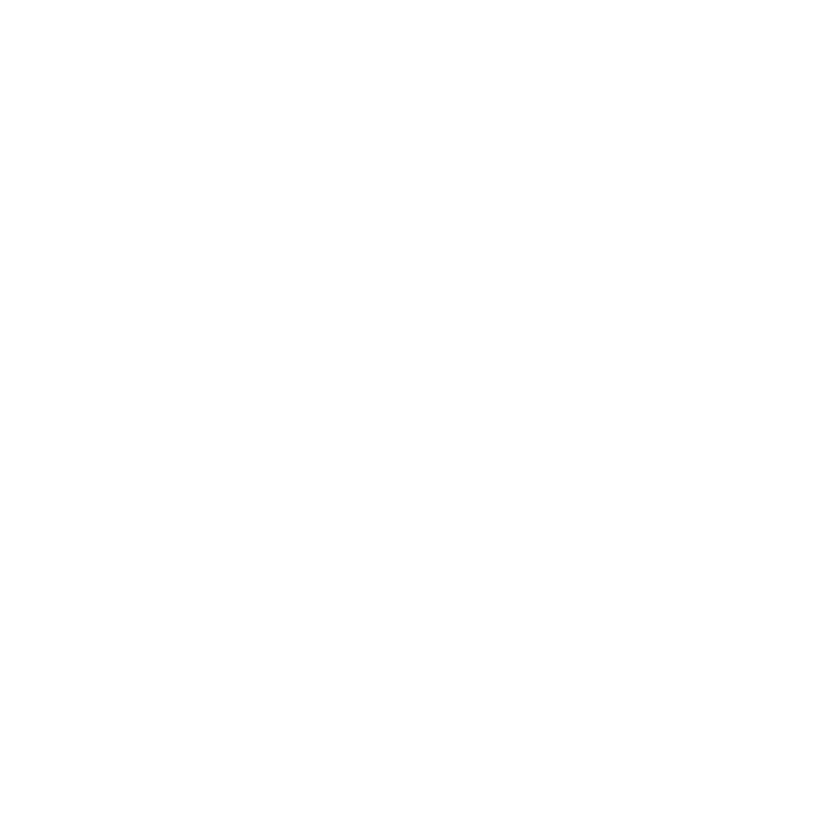

In [97]:
ggplot(df_test_computed) + 
 geom_line(aes(x = time, y=list(filter$level),size = 1,alpha = 0.4)) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "distance (meters)", x = "hour")

In [52]:
p1 = ggplot(df_test_computed) + 
 geom_line(aes(x = time, y=dist_meters),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "distance (meters)", x = "hour")

In [48]:
p2 =  ggplot(df_test_computed) + 
 geom_line(aes(x = time, y=speed_kph),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs( y = "speed(kph)", x = "hour")
p3 = ggplot(df_test_computed) + 
 geom_line(aes(x = time, y=accel_mps2),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "acceleration(mps2)", x = "hour")
p4 = ggplot(df_test_computed) + 
 geom_line(aes(x = time, y=interval_seconds),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(y = "interval_seconds", x = "hour")

Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXlt.POSIXct(x, tz):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message:
"Removed 1 row(s) containing missing values (geom_path)."
Warning message in as.POSIXlt.POSIXct(x):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning message in as.POSIXct.POSIXlt(from):
"unknown timezone '%Y:%M:%D:%H:%M:%S'"
Warning 

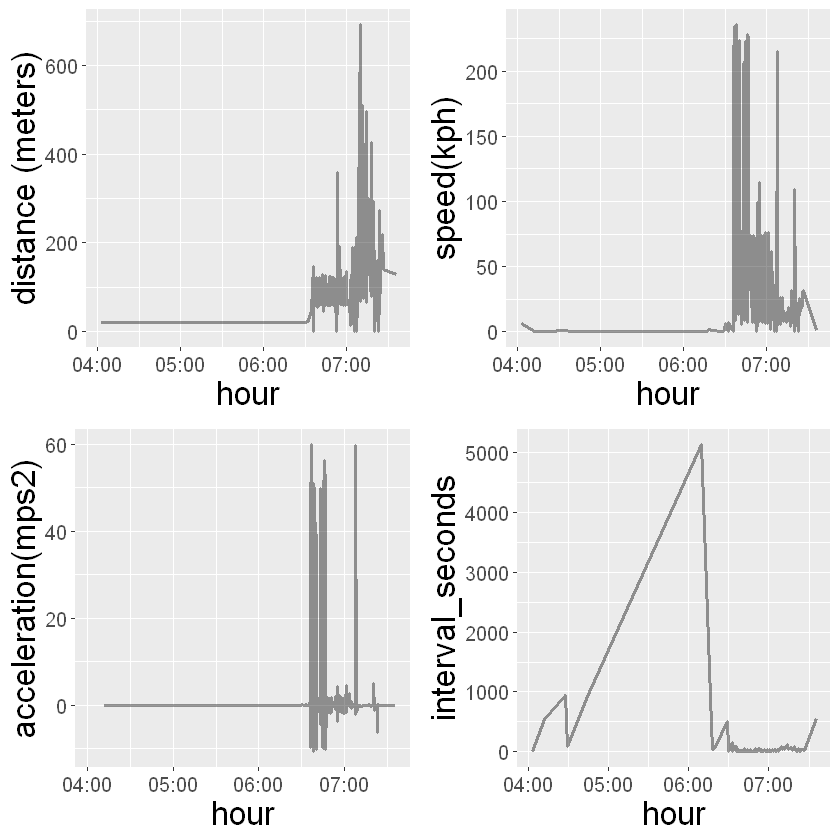

In [49]:
grid.arrange(p1, p2, p3, p4, ncol=2, nrow=2)

In [63]:
#df_test$dist_meters
filter = robreg.filter(df_test_computed$dist_meters, width=10,online=TRUE,method= "MED")

1 out of 255 time series values in df_test_computed$dist_meters are missing. 


In [101]:
filter$level

,MED
,<dbl>
1,20.55303
2,20.55303
3,20.55303
4,20.55303
5,20.55303
6,20.55303
7,20.55303
8,20.55303
9,20.55303


In [92]:
s = data.frame(filter$level)

In [76]:
s

,MED
,<dbl>
1,20.55303
2,20.55303
3,20.55303
4,20.55303
5,20.55303
6,20.55303
7,20.55303
8,20.55303
9,20.55303


In [87]:
d1$dist_meters = s

In [60]:
filter$level

,MED
,<dbl>
1,20.55303
2,20.55303
3,20.55303
4,20.55303
5,20.55303
6,20.55303
7,20.55303
8,20.55303
9,20.55303


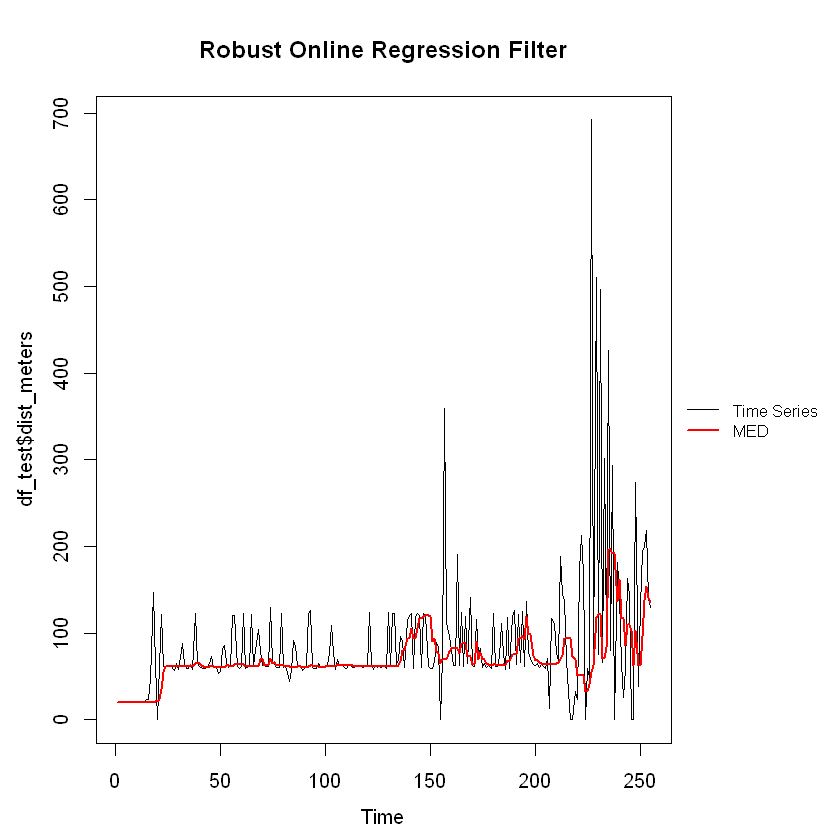

In [61]:
plot(filter)

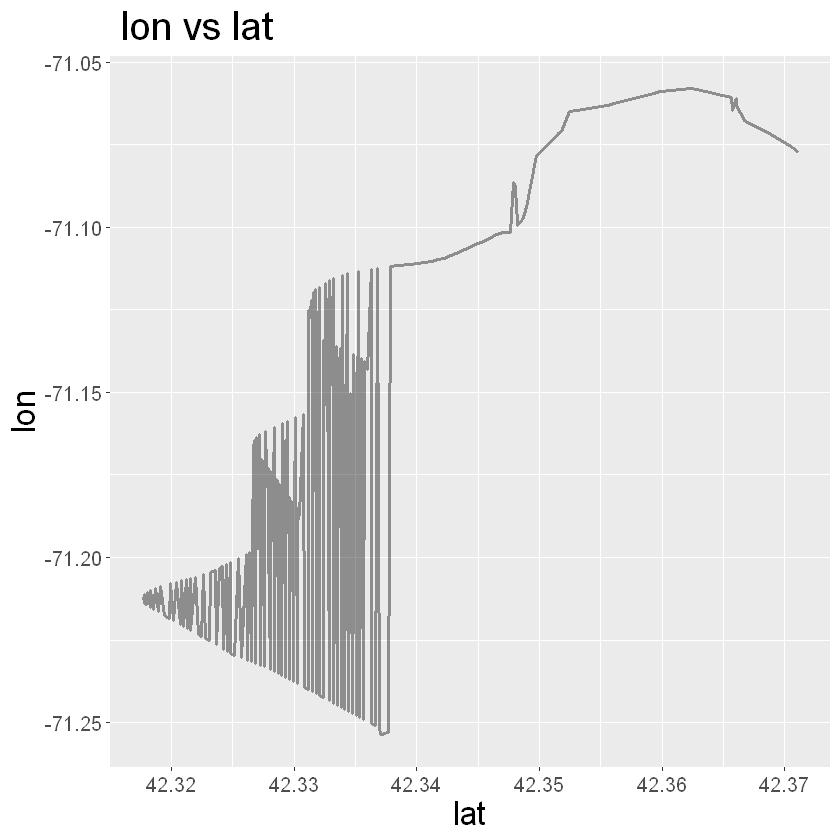

In [63]:
ggplot(df_1_10001_calculate) + 
 geom_line(aes(x=lat, y=lon),size = 1,alpha = 0.4) +
theme(axis.text=element_text(size = 12),axis.title.x = element_text(size = 20),axis.title.y = element_text(size = 20),title= element_text(size = 20))+
 labs(title =" lon vs lat ", y = "lon", x = "lat")

## Vehicle distance,speed, acceleration calculation 
### Spurious values statistics
### Value correction

In [18]:
# Function to compute distances (D), speeds (S) and acceleration (A) in meters, meters per second, km per hour and m s^-2
compute_speed_acceleration <- function(d) {
    d = data.frame(d)
#     d$dist_meters = NA
#     d$dist_meters = as.numeric(d$dist_meters)
#     d$interval_seconds = NA
#     d$interval_seconds = as.numeric(d$interval_seconds)
    d$speed_mps = NA
    d$speed_mps = as.numeric(d$speed_mps)
    d$speed_kph = NA
    d$speed_kph = as.numeric(d$speed_kph)
    d$accel_mps2 = NA
    d$accel_mps2 = as.numeric(d$accel_mps2)
    n <- nrow(d)
    diagnostics = {}
    if (n >= 2) {
#         # Compute interval distance using Haversine function
#         d$dist_meters[2:n] = distHaversine(cbind(d$lon[1:n-1],d$lat[1:n-1]),cbind(d$lon[2:n],d$lat[2:n]))
#         # Compute time interval
#         d$interval_seconds[2:n] = as.numeric(difftime(d$trxtime[2:n], d$trxtime[1:n-1], units = "secs"))
        # Compute speed in meters per second
        d$speed_mps[2:n] = d$dist_meters[2:n] / d$interval_seconds[2:n]
        # Convert speed to kph
        d$speed_kph[2:n] = d$speed_mps[2:n] * 3.6
        # # Compute accelerations
        # d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Spurious values statistics
        index_excessive_speeds = as.numeric(row.names(d[(d$speed_kph > 128) & (!is.na(d$speed_kph)),]))
        # Original data metrics calculation
         diagnostics$mean_original_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_original_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_original_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_original_speed_kph = length(as.numeric(d[, "speed_kph"]))
        # Excessive data metrics calculation
         diagnostics$mean_excess_speed_kph = mean(as.numeric(d[index_excessive_speeds, "speed_kph"]))
         diagnostics$min_excess_speed_kph = min(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$max_excess_speed_kph = max(as.numeric(d[index_excessive_speeds, "speed_kph"])) 
         diagnostics$num_excess_speed_kph = length(d[index_excessive_speeds, "speed_kph"]) 
         diagnostics$prop_excess_speed_kph = round(100*diagnostics$num_excess_speed/n, 2)
        # Correct the excessive speed values and recalculate acceleration and distance
        repeat{
        d[index_excessive_speeds, c('speed_kph',"speed_mps")] = d[index_excessive_speeds - 1 , c('speed_kph',"speed_mps")]
        d[index_excessive_speeds, "dist_meters"] = d[index_excessive_speeds, "speed_mps"] * d[index_excessive_speeds,"interval_seconds"]
        # d[index_excessive_speeds, "accel_mps2"] = (d[index_excessive_speeds, "speed_mps"] 
        #                                           - d[index_excessive_speeds - 1, "speed_mps"]) / d[index_excessive_speeds,"interval_seconds"]
        if(max(d$speed_kph,na.rm = TRUE) <= 128){break}
        }
         # Compute accelerations
         d$accel_mps2[2:n] = (d$speed_mps[2:n] - d$speed_mps[1:n-1])/d$interval_seconds[2:n]
        # Correct accelerations
         index_excessive_accelerations = as.numeric(row.names(d[(d$dist_meters == 0) & (d$accel_mps2 > 6),]))
         d[index_excessive_accelerations, "accel_mps2"] = d[index_excessive_accelerations - 1 , "accel_mps2"]
        # Corrected data metrics calculation
         diagnostics$mean_corrected_speed_kph = mean(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$min_corrected_speed_kph = min(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$max_corrected_speed_kph = max(as.numeric(d[, "speed_kph"]),na.rm=TRUE)
         diagnostics$num_corrected_speed_kph = length(as.numeric(d[, "speed_kph"]))
    }
    return(list(data = d ,diag_metrics = diagnostics))   
}

In [21]:
# Process calculation 
process_month_trajectory = function(data){
    results_df = data.frame() # empty dataframe
    diagnostics_df = data.frame()
    for(i in unique(data$day)) { 
        data_day <- data[data$day == i, ]
        # Put each train in one loop in a subset
        for (j in unique(data_day$trainid)) {
            data_day_train = data_day[data_day$trainid == j, ]        
            trajectory_and_diagnostics <- compute_trajectories(data_day_train)  
            trajectories = trajectory_and_diagnostics$data
            diagnostics = trajectory_and_diagnostics$diag_metrics          
            results_df <- rbind(results_df, trajectories)
            diagnostics_df <- rbind(diagnostics_df, diagnostics) 
        }
    }
     write.csv(x = results_df, file.path("../../data/tidy/", paste("trajectory", yy, mm, ".csv", sep = "-", collapse = "")))
    write.csv(x = diagnostics_df, file.path("../../data/tidy/", paste("trajectory-diagnostics" , yy, mm, ".csv", sep = "-",collapse = "")))
    # Uncomment the beneath line and check the computation result
    # return(list(result = results_df, result_diag = diagnostics_df ))
 }

In [ ]:
# Generate the final table
main = function(YEARLIST, MONTHLIST) {
    for (y in YEARLIST) {
        for (m in MONTHLIST) {
            df_agg = aggregate_line_trajectories(y, m)
            df_agg = preprocess_data(df_agg)
            process_month_trajectory(df_agg, y, m)            
        }
    }
}

In [ ]:
main(YEARLIST, MONTHLIST)